# GD2. ResNet Abalation Study (ResNet-34, ResNet-50)

- Ablation Study : 직역하면 제거 연구
- 딥러닝 논문은 여러 가지 방법들을 결합해 어떤 문제를 해결하는 방법을 제시함.
- 제안한 방법의 유효함을 증명하기 위해 딥러닝 논문에서는 해당 방법을 제거한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교함.
- 애블레이션 연구란 "아이디어를 제거함으로써" 제안한 방법이 어떻게 성능이나 문제 해결에 효과를 주는지 확인하는 실험임.
- ResNet의 성능을 평가하기 위해 논문과 동일한 이미지넷의 훈련/검증 데이터셋을 사용해 학습과 평가를 진행하는 것이 이상적임.
- 일반 네트워크와 ResNet을 구현해서 이 둘을 비교해 ResNet 및 residual connection의 유효성을 확인

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## Ablation Study (1) - 데이터셋 준비

### Input Normalization
- Data Normalization은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것.
- 이미지의 경우 픽셀 정보를 0\~255 사이의 값으로 갖는데, 이를 255로 나누면 0\~1.0 사이의 값을 갖게 됨.
- Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지, 딥러닝에서 Local optimum에 빠질 위험을 줄이기(학습 속도 향상) 위함임.
한 픽셀이 가진 채널 값은 픽셀의 색을 표현함.
- 모델에 넣기 전에 각 채널별 최댓값인 255로 정규화(normalize)를 해 이미지의 표현이 0과 1 사이로 들어오게 만듦.

In [2]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [3]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteM6R0IQ/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
ds_info.features["label"].names

['cat', 'dog']

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

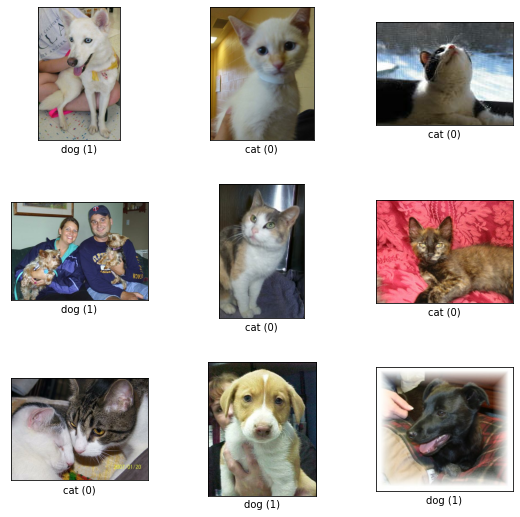

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

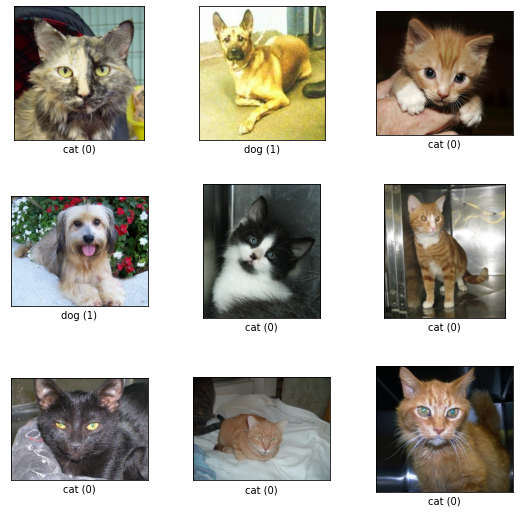

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

## Ablation Study (2) 블록 구성하기
- 모델을 구현하는 과정에서 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시 반복되는 부분을 줄여 하이퍼파라미터 혹은 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요함.
- 최근 나오는 일반적인 딥러닝 모델에서 주요 구조를 모듈화해 조금씩 바꾸어 쓸 수 있는 단위를 블록(block)이라 부름.
- 레이어(layer)는 기본적으로 텐서플로우, 케라스, 파이토치 등에서 기본적으로 제공하는 단위임.
여기서 한 단계 위인 블록을 단위로 모델을 만들 수 있어야 함.

In [10]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [11]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer

    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)

    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [12]:
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer

    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))

    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

## Ablation Study (3) ResNet Compelete Model
- 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수 만들기

In [13]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)  # Global(O) AveragePooling2D(X)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x)
    
    return model

In [14]:
def build_plain(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)

    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x)
    
    return model

### 1) ResNet-34

In [15]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False, num_classes=2)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

### 2) ResNet-34 (plain)

In [16]:
plain_34 = build_plain(input_shape=(224, 224,3), is_50=False, num_classes=2)
plain_34.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_36 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_37 (Conv2D)          (None, 56, 56, 64)        3692

### 3) ResNet-50

In [17]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True, num_classes=2)
resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_69 (BatchN  (None, 112, 112, 64  256        ['conv2d_69[0][0]']              
 ormalization)                  )                                                           

### 4) ResNet-50 (plain)

In [18]:
plain_50 = build_plain(input_shape=(224, 224,3), is_50=True, num_classes=2)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        4160

## Ablation Study (4) 비교 실험

In [19]:
BATCH_SIZE = 32
EPOCH = 15

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 93s 121ms/step - loss: 2.3546 - accuracy: 0.6204 - val_loss: 2.5189 - val_accuracy: 0.5621
Epoch 2/15
581/581 [==============================] - 68s 117ms/step - loss: 2.3029 - accuracy: 0.6744 - val_loss: 2.3602 - val_accuracy: 0.6361
Epoch 3/15
581/581 [==============================] - 68s 117ms/step - loss: 2.2586 - accuracy: 0.7062 - val_loss: 2.5760 - val_accuracy: 0.6046
Epoch 4/15
581/581 [==============================] - 68s 117ms/step - loss: 2.2074 - accuracy: 0.7460 - val_loss: 2.2384 - val_accuracy: 0.7234
Epoch 5/15
581/581 [==============================] - 68s 118ms/step - loss: 2.1435 - accuracy: 0.7891 - val_loss: 2.3486 - val_accuracy: 0.7030
Epoch 6/15
581/581 [==============================] - 68s 118ms/step - loss: 2.0874 - accuracy: 0.8190 - val_loss: 2.4499 - val_accuracy: 0.6829
Epoch 7/15
581/581 [==============================] - 68s 117ms/step - loss: 2.0170 - accuracy: 0.8548 - val_loss: 2.3384 - val_accuracy: 0.7

In [22]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 77s 113ms/step - loss: 2.2187 - accuracy: 0.5455 - val_loss: 2.4955 - val_accuracy: 0.5127
Epoch 2/15
581/581 [==============================] - 65s 112ms/step - loss: 2.2094 - accuracy: 0.5539 - val_loss: 2.2032 - val_accuracy: 0.5565
Epoch 3/15
581/581 [==============================] - 65s 112ms/step - loss: 2.2052 - accuracy: 0.5591 - val_loss: 2.2192 - val_accuracy: 0.5652
Epoch 4/15
581/581 [==============================] - 65s 112ms/step - loss: 2.1954 - accuracy: 0.5765 - val_loss: 2.2531 - val_accuracy: 0.5567
Epoch 5/15
581/581 [==============================] - 65s 112ms/step - loss: 2.1728 - accuracy: 0.6132 - val_loss: 2.6107 - val_accuracy: 0.5188
Epoch 6/15
581/581 [==============================] - 65s 112ms/step - loss: 2.1553 - accuracy: 0.6349 - val_loss: 2.2348 - val_accuracy: 0.5829
Epoch 7/15
581/581 [==============================] - 65s 112ms/step - loss: 2.1422 - accuracy: 0.6484 - val_loss: 2.2563 - val_accuracy: 0.5

In [23]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 72s 98ms/step - loss: 6.0349 - accuracy: 0.5494 - val_loss: 6.0339 - val_accuracy: 0.5393
Epoch 2/15
581/581 [==============================] - 56s 97ms/step - loss: 6.0037 - accuracy: 0.5782 - val_loss: 6.0433 - val_accuracy: 0.5591
Epoch 3/15
581/581 [==============================] - 56s 97ms/step - loss: 5.9893 - accuracy: 0.5896 - val_loss: 5.9747 - val_accuracy: 0.6115
Epoch 4/15
581/581 [==============================] - 56s 97ms/step - loss: 5.9658 - accuracy: 0.6075 - val_loss: 6.0731 - val_accuracy: 0.5358
Epoch 5/15
581/581 [==============================] - 56s 97ms/step - loss: 5.9519 - accuracy: 0.6181 - val_loss: 5.9560 - val_accuracy: 0.6182
Epoch 6/15
581/581 [==============================] - 57s 98ms/step - loss: 5.9426 - accuracy: 0.6154 - val_loss: 5.9523 - val_accuracy: 0.6247
Epoch 7/15
581/581 [==============================] - 57s 98ms/step - loss: 5.9277 - accuracy: 0.6275 - val_loss: 6.0165 - val_accuracy: 0.5721
Epo

In [24]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 109s 163ms/step - loss: 5.2398 - accuracy: 0.5451 - val_loss: 5.2732 - val_accuracy: 0.5019
Epoch 2/15
581/581 [==============================] - 94s 161ms/step - loss: 5.2265 - accuracy: 0.5549 - val_loss: 5.3185 - val_accuracy: 0.5669
Epoch 3/15
581/581 [==============================] - 94s 161ms/step - loss: 5.2212 - accuracy: 0.5588 - val_loss: 5.2937 - val_accuracy: 0.5794
Epoch 4/15
581/581 [==============================] - 94s 161ms/step - loss: 5.2135 - accuracy: 0.5606 - val_loss: 5.2172 - val_accuracy: 0.5655
Epoch 5/15
581/581 [==============================] - 94s 162ms/step - loss: 5.2078 - accuracy: 0.5548 - val_loss: 5.6559 - val_accuracy: 0.5054
Epoch 6/15
581/581 [==============================] - 94s 162ms/step - loss: 5.2043 - accuracy: 0.5547 - val_loss: 5.1944 - val_accuracy: 0.5774
Epoch 7/15
581/581 [==============================] - 94s 162ms/step - loss: 5.1952 - accuracy: 0.5597 - val_loss: 5.2161 - val_accuracy: 0.

## Ablation Study (5) 훈련 과정 시각화

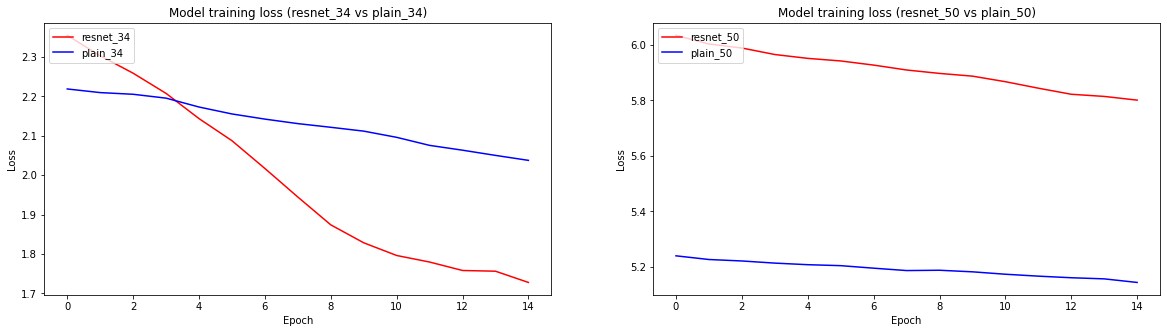

In [25]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss (resnet_34 vs plain_34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss (resnet_50 vs plain_50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

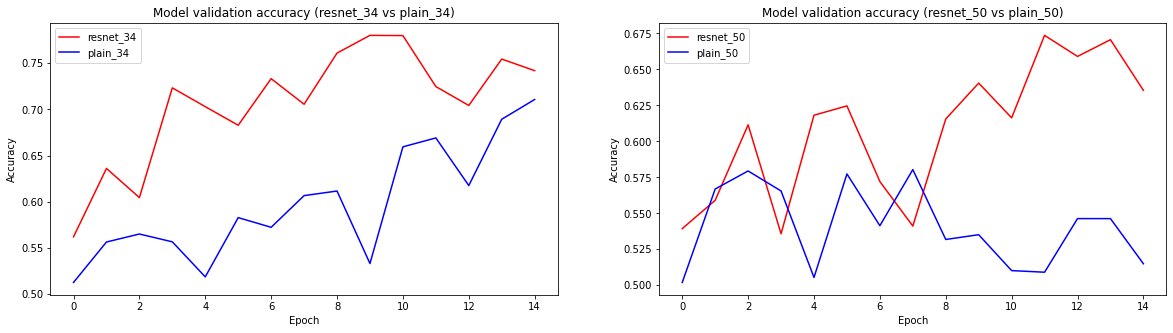

In [26]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_34 vs plain_34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_50 vs plain_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()